In [1]:
import os
import pdfplumber
import pandas as pd
import re
import subprocess

caffeinate_process = subprocess.Popen(['caffeinate', '-i', '-m', '-s'])

# Function to extract specific text from PDF
def extract_info_from_pdf(pdf_file):
    with pdfplumber.open(pdf_file) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text()
    
    # Define regex patterns for information extraction
    name_pattern = r"PERSONNE ETROITEMENT LIEE :(.*?)(?=,|$)"
    position_pattern = r",(.*?)(?=NOTIFICATION|$)"
    company_name_pattern = r"NOM :(.*?)(?=LEI|DETAIL|$)" # LEI or DETAIL to stop
    date_pattern = r"DATE DE LA TRANSACTION :(.*?)(?=LIEU|$)"
    nature_pattern = r"NATURE DE LA TRANSACTION :(.*?)(?=DESCRIPTION|$)"
    price_pattern = r"PRIX :(.*?)(?=Euro|Dollar|Livre|Franc|$)"
    volume_pattern = r"VOLUME :((?:(?!VOLUME :|TRANSACTION).)*)\s*TRANSACTION" # last occurence
    date_notification_pattern = r"DATE DE RECEPTION DE LA NOTIFICATION :(.*?)(?=COMMENTAIRES|$)"

    name = re.search(name_pattern, text, re.DOTALL)
    position = re.search(position_pattern, text, re.DOTALL)
    company_name = re.search(company_name_pattern, text, re.DOTALL)
    date_transaction = re.search(date_pattern, text, re.DOTALL)
    nature = re.search(nature_pattern, text, re.DOTALL)
    price = re.search(price_pattern, text, re.DOTALL)
    volume = re.search(volume_pattern, text, re.DOTALL)
    date_notification = re.search(date_notification_pattern, text, re.DOTALL)

    # Extracted information
    def convert_to_text(re_search_result):
        return re_search_result.group(1).strip() if re_search_result else ""
    
    name_text = convert_to_text(name)
    position_text = convert_to_text(position)
    company_name_text = convert_to_text(company_name)
    date_transaction_text = convert_to_text(date_transaction)
    nature_text = convert_to_text(nature)
    price_text = convert_to_text(price)
    volume_text = convert_to_text(volume)
    date_notification_text = convert_to_text(date_notification)

    text_dict = {'name': name_text, 'position': position_text, 'company_name': company_name_text,
                 'date_transaction': date_transaction_text, 'date_notification': date_notification_text,
                 'nature': nature_text, 'price': price_text, 'volume': volume_text}
    
    return text_dict

folder_path = "./amf-pdfs/"

# Find all PDF files in the folder
pdf_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".pdf")]
print(f'list of PDF files: {pdf_files}')
total_files = len(pdf_files)
print(f'number of PDF files: {total_files}')

data = []

# Extract information from each PDF and store it in the dataframe
for i, file in enumerate(pdf_files, 1):
    print(f'\r {i}/{total_files}',  end='', flush=True)
    new_info_dict = extract_info_from_pdf(file)
    data.append(new_info_dict)
df = pd.DataFrame(data)

df.to_pickle('amf-data-raw.pkl')

df.head(10)

caffeinate_process.terminate()

list of PDF files: ['./amf-pdfs/DD_23_885902_9706358.pdf', './amf-pdfs/DD_22_848579_9241245.pdf', './amf-pdfs/DD_22_873197_9545767.pdf', './amf-pdfs/DD_23_913145_9927087.pdf', './amf-pdfs/DD_22_873757_9553231.pdf', './amf-pdfs/DD_23_893648_9804332.pdf', './amf-pdfs/DD_23_913377_9929895.pdf', './amf-pdfs/DD_22_815707_8827457.pdf', './amf-pdfs/DD_23_879301_9623390.pdf', './amf-pdfs/DD_22_877789_9603925.pdf', './amf-pdfs/DD_23_914446_9943608.pdf', './amf-pdfs/DD_23_897368_9854028.pdf', './amf-pdfs/DD_22_833404_9052280.pdf', './amf-pdfs/DD_22_824970_8938825.pdf', './amf-pdfs/DD_22_876817_9591571.pdf', './amf-pdfs/DD_22_834822_9070591.pdf', './amf-pdfs/DD_23_880289_9635663.pdf', './amf-pdfs/DD_23_899588_9883303.pdf', './amf-pdfs/DD_22_865073_9445323.pdf', './amf-pdfs/DD_22_842912_9173472.pdf', './amf-pdfs/DD_23_893091_9796958.pdf', './amf-pdfs/DD_22_845445_9204231.pdf', './amf-pdfs/DD_22_842688_9170905.pdf', './amf-pdfs/DD_23_915700_9958928.pdf', './amf-pdfs/DD_23_914427_9943339.pdf', './am

KeyboardInterrupt: 

In [2]:
from datetime import datetime
import locale

data = pd.read_pickle('amf-data-raw.pkl')
df = pd.DataFrame(data)

# Set the French locale for month names
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Convert the 'date' column to datetime format
df['date_transaction'] = pd.to_datetime(df['date_transaction'], format='%d %B %Y', errors='coerce')
df['date_notification'] = pd.to_datetime(df['date_notification'], format='%d %B %Y', errors='coerce')

# Reset the locale to the default setting
locale.setlocale(locale.LC_TIME, '')

df.head(10)


,name,position,company_name,date_transaction,date_notification,nature,price,volume
0,MARVIK HOLDING SARL personne morale liée à Lau...,Président,GROUPE AIRWELL,2023-02-21,2023-02-22,Cession,4.6777,13 770.0000
1,James DeYonker,Directeur Juridique,EUROAPI,2022-06-20,2022-06-23,Acquisition,14.4000,416.0000
2,ARJIL COMMANDITEE-ARCO SOCIETE ANONYME personn...,PRESIDENT DIRECTEUR\nGENERAL,LAGARDERE SA,2022-11-22,2022-11-23,Acquisition,18.9857,1 860.0000
3,FINANCIERE AGACHE société anonyme personne mor...,Président-directeur général,LVMH MOET HENNESSY-LOUIS VUITTON,2023-06-01,2023-06-02,Acquisition,808.1031,30 936.0000
4,The Home Bar Bevtech LTD personne morale liée ...,Président Directeur Général,SMART GOOD THINGS HOLDING S.A.,2022-11-28,2022-11-28,Cession,158.0000,265.0000
5,FIRMAMENT PARTICIPATIONS société en commandite...,Administrateur,FREY,2023-04-05,2023-04-07,Acquisition,34.0000,50.0000
6,Jean-Claude Maurel,Président du Directoire,MEDESIS PHARMA S.A.,2023-05-23,2023-06-05,Cession,2.2000,3 140.0000
7,HERITAGE VENTURES LIMITED Private Company Limi...,Shareholder,AIRTIME PARTECIPAZIONI S.P.A.,2022-01-11,2022-01-11,Cession,74.8000,135.0000
8,NAMITA SHAH,Membre du Comité exécutif,TOTALENERGIES SE,2023-01-02,2023-01-09,Acquisition,59.7451,444.3769
9,Paul DU SAILLANT,Directeur Général Délégué,ESSILORLUXOTTICA,2022-12-23,2022-12-29,Cession,169.8530,8 831.7470


In [3]:
# Ensure Price and Volume are Float values
df['price'] = df['price'].astype(str).str.replace(' ', '').astype(float)
df['volume'] = df['volume'].astype(str).str.replace(' ', '').astype(float)
df.tail(10)

,name,position,company_name,date_transaction,date_notification,nature,price,volume
7631,STEPHANE GERART,CIO - Directeur BU IA - Membre du comex,ONCODESIGN,2022-10-18,2022-10-20,Cession,14.4200,17640.0
7632,ISABELLE SIMON,Secrétaire général,THALES,2022-09-28,2022-09-28,Acquisition gratuite d'actions,0.0000,2493.0
7633,OCTOPUS société civile personne morale liée à ...,Président du conseil de surveillance,UNIBEL,2023-05-15,2023-05-17,Apport en nature,974.0000,163246.0
7634,BOUYGUES SA,"ADMINISTRATEUR DE TF1, FILIALE DIRECTE DE BOUY...",TELEVISION FRANCAISE 1,2022-08-16,2022-08-17,Acquisition,6.7872,10000.0
7635,HOLDING HR Société par actions simplifiée pers...,Président Directeur Général,HYDROGEN-REFUELING-SOLUTIONS SA,2022-02-08,2022-02-10,Cession,34.8650,102108.0
7636,BOUYGUES SA,"ADMINISTRATEUR DE TF1, FILIALE DIRECTE DE BOUY...",TELEVISION FRANCAISE 1,2022-05-05,2022-05-06,Acquisition,7.9532,34000.0
7637,Aymerick PENICAUT,PDG,ASHLER & MANSON,2022-08-17,2022-08-19,Cession,2.8400,242.0
7638,CAMAHËAL Finance S.A. personne morale liée à J...,PDG,ALAN ALLMAN ASSOCIATES,2022-01-04,2022-01-07,Cession,15.2172,1638.0
7639,Kerry-Jane Wallart personne liée à Romain Desr...,Directeur Général Délégué,NEOEN,2022-06-23,2022-06-27,Paiement dividende en actions,33.9900,78.0
7640,Eric BAISSUS,President du Directoire de Kalray,KALRAY,2022-08-10,2022-10-18,Cession,23.1546,2500.0


In [4]:
# company_names = df['company_name'].unique()

# ticker_mapping = {}

# for company_name in company_names:
#     ticker_mapping[company_name] = '.PA'

# ticker_mapping = dict(sorted(ticker_mapping.items()))

# print(ticker_mapping)

import ticker_mapping
ticker_mapping = ticker_mapping.ticker_mapping

In [5]:
company_names = df['company_name'].unique()
missing_keys = [company_name for company_name in company_names if company_name not in ticker_mapping]
print(f'missing keys: {missing_keys}')

df['ticker'] = df['company_name'].map(ticker_mapping)

df.head(15)

missing keys: []


,name,position,company_name,date_transaction,date_notification,nature,price,volume,ticker
0,MARVIK HOLDING SARL personne morale liée à Lau...,Président,GROUPE AIRWELL,2023-02-21,2023-02-22,Cession,4.6777,13770.0000,ALAIR.PA
1,James DeYonker,Directeur Juridique,EUROAPI,2022-06-20,2022-06-23,Acquisition,14.4000,416.0000,EAPI.PA
2,ARJIL COMMANDITEE-ARCO SOCIETE ANONYME personn...,PRESIDENT DIRECTEUR\nGENERAL,LAGARDERE SA,2022-11-22,2022-11-23,Acquisition,18.9857,1860.0000,MMB.PA
3,FINANCIERE AGACHE société anonyme personne mor...,Président-directeur général,LVMH MOET HENNESSY-LOUIS VUITTON,2023-06-01,2023-06-02,Acquisition,808.1031,30936.0000,MC.PA
4,The Home Bar Bevtech LTD personne morale liée ...,Président Directeur Général,SMART GOOD THINGS HOLDING S.A.,2022-11-28,2022-11-28,Cession,158.0000,265.0000,MLSGT.PA
5,FIRMAMENT PARTICIPATIONS société en commandite...,Administrateur,FREY,2023-04-05,2023-04-07,Acquisition,34.0000,50.0000,FREY.PA
6,Jean-Claude Maurel,Président du Directoire,MEDESIS PHARMA S.A.,2023-05-23,2023-06-05,Cession,2.2000,3140.0000,ALMDP.PA
7,HERITAGE VENTURES LIMITED Private Company Limi...,Shareholder,AIRTIME PARTECIPAZIONI S.P.A.,2022-01-11,2022-01-11,Cession,74.8000,135.0000,ALMEX.PA
8,NAMITA SHAH,Membre du Comité exécutif,TOTALENERGIES SE,2023-01-02,2023-01-09,Acquisition,59.7451,444.3769,TTE.PA
9,Paul DU SAILLANT,Directeur Général Délégué,ESSILORLUXOTTICA,2022-12-23,2022-12-29,Cession,169.8530,8831.7470,EL.PA


In [6]:
import yfinance as yf
from datetime import timedelta

caffeinate_process = subprocess.Popen(['caffeinate', '-i', '-m', '-s'])

# Get current and future stock prices and variations
def get_stock_prices(row):
    try:
        ticker = row['ticker']
        start_day = row['date_transaction']
        end_day = start_day + timedelta(days=90)
        start_day = start_day.strftime('%Y-%m-%d')
        end_day = end_day.strftime('%Y-%m-%d')

        stock = yf.Ticker(ticker)
        stock_data = stock.history(start=start_day, end=end_day)
        # prices = stock_data['Open'].values
        prices = stock_data['Open']
        initial_price = prices.iloc[0]

        # min_price, max_price = min(prices.values), max(prices.values)
        # min_index, max_index = prices.index(min_price), prices.index(max_price)
        min_price = prices.min()
        max_price = prices.max()

        min_index = prices.index.get_loc(prices.idxmin())
        max_index = prices.index.get_loc(prices.idxmax())

        return pd.Series({
            'stock_price_d0': initial_price,
            'var_min': min_price / initial_price,
            'min_index': min_index,
            'var_max': max_price / initial_price,
            'max_index': max_index,
            'var_d1': prices[1] / initial_price,
            'var_d3': prices[3] / initial_price,
            'var_d5': prices[5] / initial_price,
            'var_d10': prices[10] / initial_price,
            'var_d20': prices[20] / initial_price,
            'var_d30': prices[30] / initial_price,
            'var_d60': prices[60] / initial_price
        })
    except:
        return pd.Series({
            'stock_price_d0': float('nan'),
            'var_min': float('nan'),
            'min_index': float('nan'),
            'var_max': float('nan'),
            'max_index': float('nan'),
            'var_d1': float('nan'),
            'var_d3': float('nan'),
            'var_d5': float('nan'),
            'var_d10': float('nan'),
            'var_d20': float('nan'),
            'var_d30': float('nan'),
            'var_d60': float('nan')
        })

# Applying the function to new columns
df = pd.concat([df, df.apply(get_stock_prices, axis=1)], axis=1)

df.to_pickle('amf-data.pkl')

caffeinate_process.terminate()

- ???.PA: No data found for this date range, symbol may be delisted
- UMS.PA: No data found for this date range, symbol may be delisted
- ???.PA: No data found for this date range, symbol may be delisted
- ???.PA: No data found for this date range, symbol may be delisted
- URW.PA: Data doesn't exist for startDate = 1649196000, endDate = 1656972000
- EDF.PA: No data found, symbol may be delisted
- ???.PA: No data found for this date range, symbol may be delisted
- TCHCS.PA: Data doesn't exist for startDate = 1650319200, endDate = 1658095200
- ???.PA: No data found for this date range, symbol may be delisted
- ???.PA: No data found for this date range, symbol may be delisted
- ???.PA: No data found for this date range, symbol may be delisted
- URW.PA: Data doesn't exist for startDate = 1647817200, endDate = 1655589600
- UMS.PA: No data found for this date range, symbol may be delisted
- ???.PA: No data found for this date range, symbol may be delisted
- URW.PA: Data doesn't exist for sta

In [7]:
df.head(15)

,name,position,company_name,date_transaction,date_notification,nature,price,volume,ticker,stock_price_d0,...,min_index,var_max,max_index,var_d1,var_d3,var_d5,var_d10,var_d20,var_d30,var_d60
0,MARVIK HOLDING SARL personne morale liée à Lau...,Président,GROUPE AIRWELL,2023-02-21,2023-02-22,Cession,4.6777,13770.0000,ALAIR.PA,4.600000,...,0.0,1.630435,55.0,1.086957,1.108696,1.152174,1.152174,1.108696,1.239130,1.543478
1,James DeYonker,Directeur Juridique,EUROAPI,2022-06-20,2022-06-23,Acquisition,14.4000,416.0000,EAPI.PA,14.190000,...,0.0,1.223044,62.0,1.037350,1.000705,1.027907,1.120507,1.131783,1.159408,1.169133
2,ARJIL COMMANDITEE-ARCO SOCIETE ANONYME personn...,PRESIDENT DIRECTEUR\nGENERAL,LAGARDERE SA,2022-11-22,2022-11-23,Acquisition,18.9857,1860.0000,MMB.PA,19.000000,...,19.0,1.156842,62.0,1.017895,1.007368,1.001053,1.037895,1.012632,1.089474,1.069474
3,FINANCIERE AGACHE société anonyme personne mor...,Président-directeur général,LVMH MOET HENNESSY-LOUIS VUITTON,2023-06-01,2023-06-02,Acquisition,808.1031,30936.0000,MC.PA,816.000000,...,55.0,1.071446,29.0,1.014583,0.992892,1.005760,1.039828,1.047917,1.069118,0.974632
4,The Home Bar Bevtech LTD personne morale liée ...,Président Directeur Général,SMART GOOD THINGS HOLDING S.A.,2022-11-28,2022-11-28,Cession,158.0000,265.0000,MLSGT.PA,158.000000,...,8.0,1.658228,63.0,1.012658,1.025316,1.031646,1.056962,1.202532,1.373418,1.582278
5,FIRMAMENT PARTICIPATIONS société en commandite...,Administrateur,FREY,2023-04-05,2023-04-07,Acquisition,34.0000,50.0000,FREY.PA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Jean-Claude Maurel,Président du Directoire,MEDESIS PHARMA S.A.,2023-05-23,2023-06-05,Cession,2.2000,3140.0000,ALMDP.PA,2.220000,...,27.0,1.000000,0.0,0.986486,0.900901,0.905405,0.896396,0.815315,0.639640,0.628378
7,HERITAGE VENTURES LIMITED Private Company Limi...,Shareholder,AIRTIME PARTECIPAZIONI S.P.A.,2022-01-11,2022-01-11,Cession,74.8000,135.0000,ALMEX.PA,74.809998,...,63.0,1.002540,1.0,1.002540,0.962572,0.962438,0.965112,1.002540,1.002540,0.899211
8,NAMITA SHAH,Membre du Comité exécutif,TOTALENERGIES SE,2023-01-02,2023-01-09,Acquisition,59.7451,444.3769,TTE.PA,58.500000,...,55.0,1.031624,33.0,1.022222,0.981197,0.991453,1.025641,0.988889,1.014359,0.897778
9,Paul DU SAILLANT,Directeur Général Délégué,ESSILORLUXOTTICA,2022-12-23,2022-12-29,Cession,169.8530,8831.7470,EL.PA,171.649994,...,56.0,1.032042,10.0,0.999417,0.984562,0.996213,1.032042,1.016895,1.025634,0.929508


In [1]:
import pandas as pd

# Test if cession and acquisition future variation are going up or down
amf_data = pd.read_pickle('amf-data.pkl')
amf_df = pd.DataFrame(amf_data)

amf_df = amf_df[(amf_df['date_transaction'] >= '2022-01-01') & (amf_df['date_transaction'] <= '2022-04-30')]

amf_df = amf_df[amf_df['price'] != 0]

# amf_df = amf_df[amf_df['position'].isin([
#     'Président Directeur Général', 'PDG',
#     'Président-Directeur Général', 'président-directeur général',
#     'DIRECTEUR', 'Directeur Général', 'DIRIGEANT',
#     'Directeur général', 'P.D.-G.'])]

print(f'data length: {len(amf_df)}')

df_cession = amf_df[amf_df['nature'] == 'Cession']
# df_acquisition = amf_df[amf_df['nature'] == 'Acquisition']
df_acquisition = amf_df[amf_df['nature'] != 'Cession']

var_means = {
    'cession': {
        'd1': df_cession['var_d1'].mean(),
        'd3': df_cession['var_d3'].mean(),
        'd5': df_cession['var_d5'].mean(),
        'd10': df_cession['var_d10'].mean(),
        'd20': df_cession['var_d20'].mean(),
        'd30': df_cession['var_d30'].mean(),
        'd60': df_cession['var_d60'].mean(),
    },
    'acquisition' : {
        'd1': df_acquisition['var_d1'].mean(),
        'd3': df_acquisition['var_d3'].mean(),
        'd5': df_acquisition['var_d5'].mean(),
        'd10': df_acquisition['var_d10'].mean(),
        'd20': df_acquisition['var_d20'].mean(),
        'd30': df_acquisition['var_d30'].mean(),
        'd60': df_acquisition['var_d60'].mean(),
    }
}

var_medians = {
    'cession': {
        'd1': df_cession['var_d1'].median(),
        'd3': df_cession['var_d3'].median(),
        'd5': df_cession['var_d5'].median(),
        'd10': df_cession['var_d10'].median(),
        'd20': df_cession['var_d20'].median(),
        'd30': df_cession['var_d30'].median(),
        'd60': df_cession['var_d60'].median()
    },
    'acquisition' : {
        'd1': df_acquisition['var_d1'].median(),
        'd3': df_acquisition['var_d3'].median(),
        'd5': df_acquisition['var_d5'].median(),
        'd10': df_acquisition['var_d10'].median(),
        'd20': df_acquisition['var_d20'].median(),
        'd30': df_acquisition['var_d30'].median(),
        'd60': df_acquisition['var_d60'].median()
    }
}

var_means = {key: {inner_key: round(inner_value, 2) for inner_key, inner_value in value.items()} for key, value in var_means.items()}
var_medians = {key: {inner_key: round(inner_value, 2) for inner_key, inner_value in value.items()} for key, value in var_medians.items()}

print(var_means)
print(var_medians)

data length: 1222
{'cession': {'d1': 1.0, 'd3': 0.99, 'd5': 0.98, 'd10': 0.97, 'd20': 0.97, 'd30': 0.97, 'd60': 0.94}, 'acquisition': {'d1': 1.0, 'd3': 1.0, 'd5': 1.01, 'd10': 1.0, 'd20': 0.99, 'd30': 1.0, 'd60': 0.97}}
{'cession': {'d1': 1.0, 'd3': 1.0, 'd5': 0.99, 'd10': 0.98, 'd20': 0.98, 'd30': 0.97, 'd60': 0.95}, 'acquisition': {'d1': 1.0, 'd3': 1.0, 'd5': 1.0, 'd10': 1.0, 'd20': 0.99, 'd30': 1.0, 'd60': 0.96}}



    amf_df length: 122178
    valuable_df length: 45276
    %_valuable: 0.37



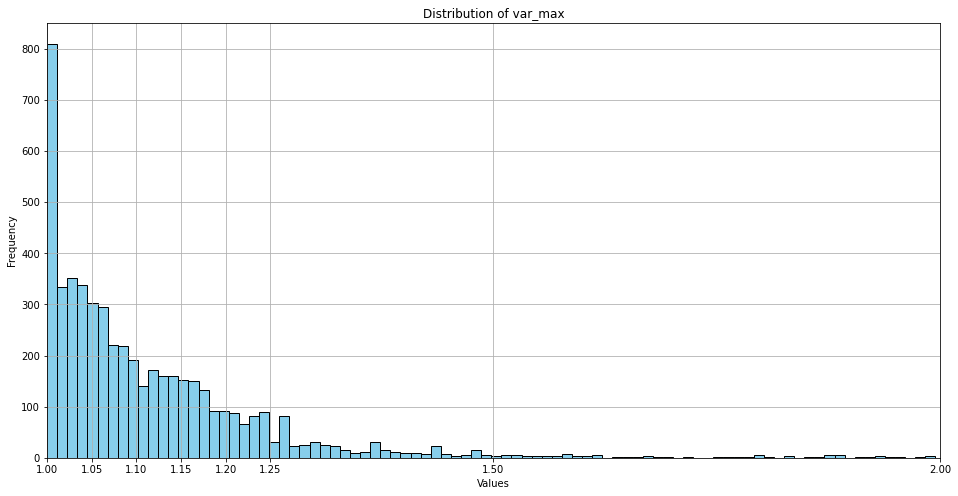

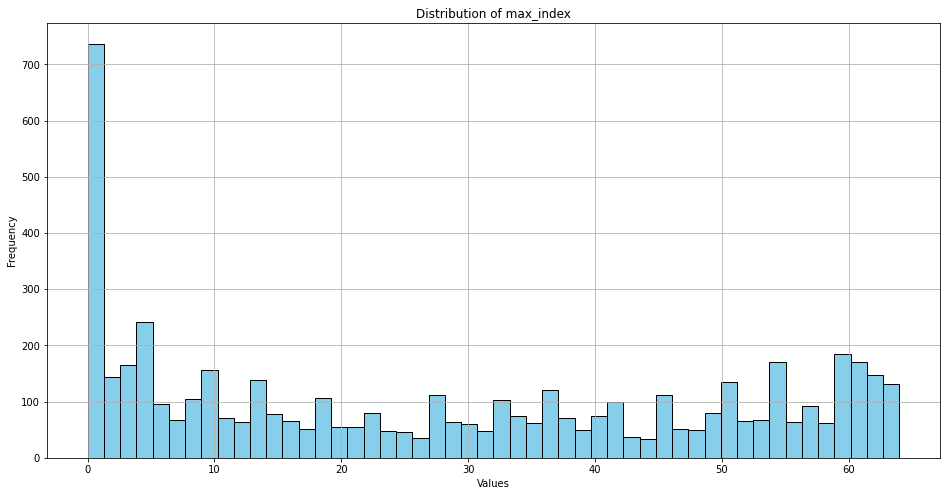

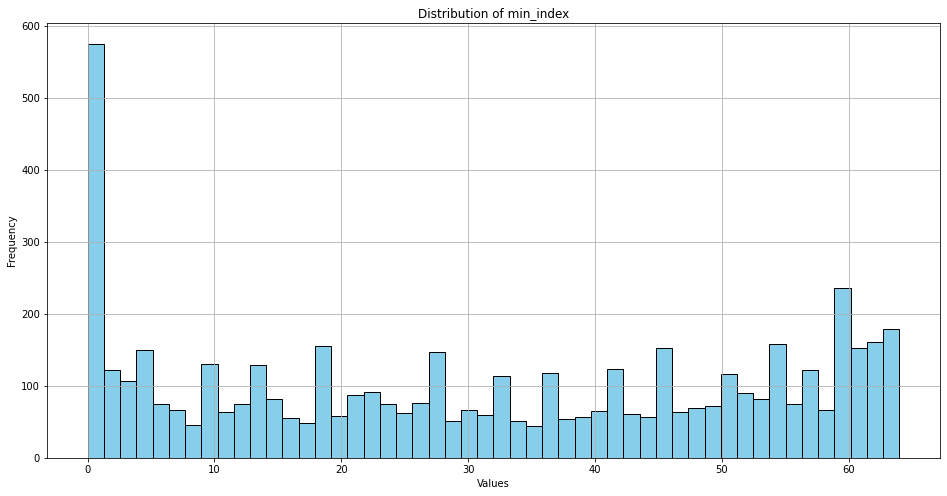

In [15]:
import matplotlib.pyplot as plt

amf_data = pd.read_pickle('amf-data.pkl')
amf_df = pd.DataFrame(amf_data)
amf_df = amf_df[amf_df['nature'] != 'Cession']

target_pct = 0.10

# mask = (
#     (amf_df['var_d1'] > 1 + target_pct) |
#     (amf_df['var_d3'] > 1 + target_pct) |
#     (amf_df['var_d5'] > 1 + target_pct) |
#     (amf_df['var_d10'] > 1 + target_pct)
# )

# valuable_df = amf_df[mask]

valuable_df = amf_df[amf_df['var_max'] > 1 + target_pct]

print(f"""
    amf_df length: {amf_df.size}
    valuable_df length: {valuable_df.size}
    %_valuable: {round(valuable_df.size / amf_df.size, 2)}
""")

plt.figure(figsize=(16, 8))
amf_df['var_max'].hist(bins=250, color='skyblue', edgecolor='black')
plt.title('Distribution of var_max')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks([1, 1.05, 1.1, 1.15, 1.2, 1.25, 1.5, 2])
plt.xlim(1, 2) 

plt.show()

plt.figure(figsize=(16, 8))
amf_df['max_index'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of max_index')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

plt.figure(figsize=(16, 8))
amf_df['min_index'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of min_index')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

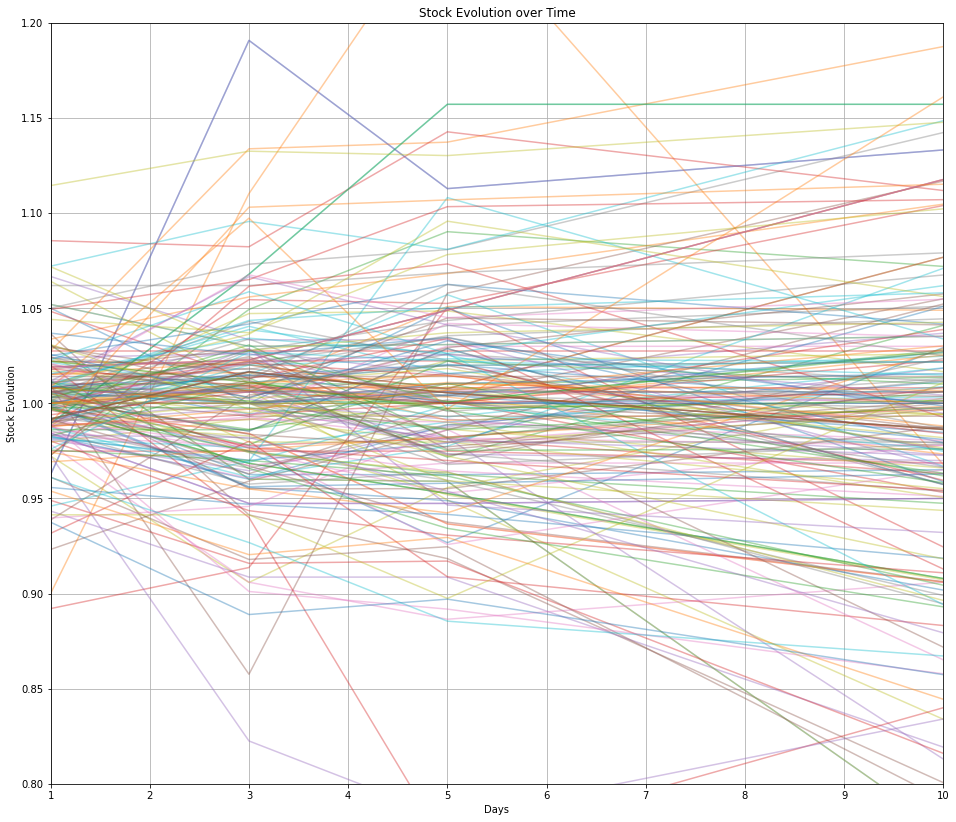

In [4]:
import matplotlib.pyplot as plt

# Assuming df contains columns: 'var_d1', 'var_d3', 'var_d5'
# Replace 'df' with the name of your DataFrame
# Assuming the index contains the stock names

columns_to_plot = ['var_d1', 'var_d3', 'var_d5', 'var_d10', 'var_d20', 'var_d30', 'var_d60']

downsampled_df = amf_df.iloc[::5]

plt.figure(figsize=(16, 14))

for index, row in downsampled_df.iterrows():
    plt.plot([1, 3, 5, 10, 20, 30, 60], row[columns_to_plot].values, alpha=0.4, label=index)

plt.xlabel('Days')
plt.ylabel('Stock Evolution')
plt.grid(True)
plt.title('Stock Evolution over Time')

plt.xlim(1, 10)
plt.ylim(0.8, 1.2)
plt.show()

In [9]:
import pandas as pd

# Test if cession and acquisition future variation are going up or down
amf_data = pd.read_pickle('amf-data.pkl')
amf_df = pd.DataFrame(amf_data)
amf_df = amf_df.sort_values(by='var_d5', ascending=False)

pivot_table = pd.pivot_table(amf_df, values=['var_d1', 'var_d3', 'var_d5', 'var_d10', 'var_d20', 'var_d30', 'ticker', 'date_transaction'],
                       index=['position', 'nature'], aggfunc={'var_d1': 'median',
                                                    'var_d3': 'median',
                                                    'var_d5': ['median', 'count'],
                                                    'var_d10': 'median',
                                                    'var_d20': 'median',
                                                    'var_d30': 'median',
                                                    'ticker': 'unique',
                                                    'date_transaction': 'nunique'})

pivot_table = pivot_table.sort_values(by=('var_d3', 'median'), ascending=False)

pd.set_option('display.max_rows', None)  # Show all rows
# amf_df.head(200)
pivot_table.head(100)


date_transaction  \
                                                                                                               nunique   
position                                           nature                                                                
Administrateur et directeur général délégué        Nantissement                                                      1   
CHAIRMAN OF THE BOARD OF\nDIRECTORS OF IKONISYS... Cession                                                           1   
Holding                                            Acquisition                                                       2   
Président Directeur-Général                        Cession                                                           2   
Directeur Business Unit Portuaire, Aéroportuair... Acquisition                                                       1   
Directeur Commercial membre du COMEX               Acquisition                                                       1   
President of Gaussin Asia Pacific                  definitive acquisition of the free share allocated                1   
Vice President of Customer Operations              Acquisition of free shares”                                       1   
Executive Vice President                           Aquisition d'Actions Gratuites                                    1   
ADMINISTRATEUR                                     Conversion                                                        2   
Directeur Administratif et Financier               Cession                                                           1   
président conseil de surveillance                  Acquisition                                                       1   
Mmebre du conseil de surveillance                  Acquisition                                                       1   
Associe - administrateur                           Acquisition                                                       1   
III, Chairman & CEO                                Acquisition                                                       2   
Secrétaire général et Secrétaire du Comité Exéc... Acquisition                                                       1   
Directeur général adjoint en charge des opérations Acquisition                                                       1   
Directrice des enseignes Casino                    Acquisition                                                       1   
Directrice du M&A Groupe                           Acquisition                                                       1   
gérant                                             Acquisition                                                       5   
DIRECTEUR                                          Acquisition                                                      14   
Chief Operating Officer et Senior Executive VP ... Souscription                                                      1   
DIRECTEUR GENERAL DELEGUE                          DENOUEMENT DU CONTRAT D'ACQUISITION D'ACTIONS U...                1   
                                                   AVENANT AU CONTRAT D'ACQUISITION D'ACTIONS UBIS...                1   
PDG                                                Acquisition définitive des actions gratuites at...                2   
Personne morale liée à Francesco MILLERI Présid... Acquisition                                                       1   
CHAIRMAN AND CEO                                   Cession                                                           1   
                                                   Acquisition                                                       1   
CENSEUR                                            Souscription                                                      1   
Présidente du conseil d'administration             Acquisition                                                       1   
GENERAL MANAGER                                    Prêt                     

In [10]:
pivot_table2 = pd.pivot_table(amf_df, values=['var_d1', 'var_d3', 'var_d5', 'var_d10', 'var_d20', 'var_d30', 'date_transaction'],
                       index=['ticker', 'nature'], aggfunc={'var_d1': 'median',
                                                    'var_d3': 'median',
                                                    'var_d5': ['median', 'count'],
                                                    'var_d10': 'median',
                                                    'var_d20': 'median',
                                                    'var_d30': 'median',
                                                    'date_transaction': 'nunique'})
pivot_table2 = pivot_table2.sort_values(by=('var_d5', 'median'), ascending=False)

pivot_table2.head(50)

date_transaction  \
                                                                     nunique   
ticker   nature                                                                
MBWS.PA  Acquisition                                                       1   
ALGEC.PA Acquisition                                                       1   
ALMAS.PA Acquisition                                                       1   
TNG.PA   Acquisition                                                       1   
DBV.PA   Souscription                                                      1   
ARTE.PA  Acquisition                                                       2   
ALKLA.PA Acquisition                                                       7   
ALPAR.PA Acquisition                                                       1   
AURE.PA  Souscription                                                      2   
ALAMA.PA Acquisition                                                      15   
ALBOO.PA Acquisition                                                       3   
ALGAU.PA Acquisition of free shares”                                       1   
         Aquisition d'Actions Gratuites                                    1   
         definitive acquisition of the free share allocated                1   
         Acquisition                                                       4   
ALECO.PA Acquisition                                                       1   
ABNX.PA  Acquisition                                                       1   
ARTE.PA  Cession                                                           1   
ALEMV.PA Acquisition                                                       1   
ALAST.PA Acquisition                                                       1   
ALALO.PA Cession                                                           1   
ALMIB.PA Attribution actions gratuites                                     1   
UBI.PA   AVENANT AU CONTRAT D'ACQUISITION D'ACTIONS UBIS...                1   
ALOPM.PA Apport                                                            1   
         Cession                                                           3   
ALMEX.PA Acquisition                                                      12   
ALCBI.PA Prêt                                                              5   
BLV.PA   Acquisition                                                       1   
ALEMV.PA Actions Gratuites                                                 1   
CGG.PA   Sell to cover                                                     1   
         Attribution définitive d'actions de performance                   1   
UBI.PA   DENOUEMENT DU CONTRAT D'ACQUISITION D'ACTIONS U...                1   
ALGAU.PA Acquisition définitive des actions gratuites at...                2   
NEX.PA   Souscription                                                      1   
PVL.PA   Apport en nature d'actions Plastiques du Val de...                1   
ATO.PA   Acquisition définitive d'actions soumises à con...                1   
PIG.PA   Acquisition                                                       5   
ALUVI.PA Cession                                                           1   
ABVX.PA  Acquisition                                                       2   
AKE.PA   attribution définitive d'actions de performance                   1   
ABNX.PA  Acquisition d'actions gratuites de performance                    1   
OREGE.PA Acquisition                                                      12   
CO.PA    Acquisition                                                       9   
ALHAF.PA Acquisition                                                       1   
RBO.PA   acquisition définitive d'actions gratuites                        2   
         Acquisition definitive d'actions gratuites                        1   
NEOEN.PA Apport d'actions à une société                                    2   
MLEFA.PA Attribution d'actions gratuites                    

In [11]:
pivot_table3 = pd.pivot_table(amf_df, values=['var_d1', 'var_d3', 'var_d5', 'var_d10', 'var_d20', 'var_d30', 'date_transaction'],
                       index=['name', 'company_name', 'nature'], aggfunc={'var_d1': 'median',
                                                    'var_d3': 'median',
                                                    'var_d5': ['median', 'count'],
                                                    'var_d10': 'median',
                                                    'var_d20': 'median',
                                                    'var_d30': 'median',
                                                    'date_transaction': 'nunique'})
pivot_table3 = pivot_table3.sort_values(by=('var_d5', 'median'), ascending=False)

pivot_table3.head(50)

date_transaction  \
                                                                                                                                                  nunique   
name                                               company_name                       nature                                                                
P.C.G. société civile personne morale liée à PH... ONCODESIGN PRECISION MEDICINE S.A. Acquisition                                                       1   
COMPAGNIE FINANCIERE DE PRISES DE PARTICIPATION... MARIE BRIZARD WINE AND SPIRITS     Acquisition                                                       1   
SERGE BITBOUL                                      GECI INTERNATIONAL                 Acquisition                                                       1   
XLP HOLDING SAS personne morale liée à SERGE BI... GECI INTERNATIONAL                 Acquisition                                                       1   
MASTRAD SA                                         MASTRAD                            Acquisition                                                       1   
HBR INVESTMENT GROUP SAS                           BOOSTHEAT                          Acquisition                                                       1   
Jan HOFLACK                                        ONCODESIGN PRECISION MEDICINE S.A. Acquisition                                                       1   
Alessandro RIVA                                    TRANSGENE S.A.                     Acquisition                                                       1   
Bpifrance Participations SA personne morale lié... DBV TECHNOLOGIES                   Souscription                                                      1   
HERITAGE VENTURES LIMITED Private Company Limit... AIRTIME PARTECIPAZIONI S.P.A.      Acquisition                                                       4   
DISTRIBUTION CASINO FRANCE Société par actions ... SMART GOOD THINGS HOLDING S.A.     Souscription                                                      1   
Yseulys COSTES                                     1000MERCIS                         Nantissement                                                      1   
Thibaut Munier                                     1000MERCIS                         Nantissement                                                      1   
VERONIQUE STAAT                                    FORSEE POWER                       Acquisition                                                       1   
ARTEME                                             ARTEA                              Acquisition                                                       2   
Gérard GUILLEMOT                                   AMA CORPORATION PLC                Acquisition                                                      14   
Julien Parrou personne liée à Saint-Florentin P... KLARSEN                            Acquisition                                                       5   
Nami Itoh-Korsholm                                 AMA CORPORATION PLC                Acquisition                                                       1   
PM SAS personne morale liée à MARCHÉ PATRICK       NEOLIFE                            Acquisition                                                       1   
Marc De Laître                                     GROUPE PAROT                       Acquisition                                                       1   
AFI.ESCA SA personne morale liée à CHRISTIAN BU... TELEVERBIER SA                     Acquisition                                                       1   
JOEL PICARD                                        AUREA                              Souscription                                                      1   
NORTHBROOK BELGIUM Société anonyme personne mor... AUREA                              Souscription                                                      1   
Christophe GAUSSIN                                 GAUS

In [12]:
selection_df = amf_df[amf_df['company_name'] == 'AMA CORPORATION PLC']
selection_df.sort_values(by='var_d3', ascending=False)
selection_df.head(30)

,name,position,company_name,date_transaction,date_notification,nature,price,volume,ticker,stock_price_d0,...,min_index,var_max,max_index,var_d1,var_d3,var_d5,var_d10,var_d20,var_d30,var_d60
2862,Gérard GUILLEMOT,DIRECTEUR,AMA CORPORATION PLC,2022-05-11,2022-05-13,Acquisition,1.6400,7861.0,ALAMA.PA,1.540,...,38.0,1.571429,8.0,1.087662,1.233766,1.389610,1.480519,0.876623,0.454545,0.481818
6640,Gérard GUILLEMOT,DIRECTEUR,AMA CORPORATION PLC,2022-05-13,2022-05-16,Acquisition,1.8849,15980.0,ALAMA.PA,1.720,...,36.0,1.406977,6.0,1.104651,1.244186,1.372093,1.136628,0.732558,0.338372,0.429070
6733,Gérard GUILLEMOT,DIRECTEUR,AMA CORPORATION PLC,2022-05-12,2022-05-13,Acquisition,1.7013,2371.0,ALAMA.PA,1.675,...,37.0,1.444776,7.0,1.026866,1.182090,1.355224,1.194030,0.740299,0.382090,0.437015
3599,Gérard GUILLEMOT,DIRECTEUR,AMA CORPORATION PLC,2022-05-10,2022-05-13,Acquisition,1.5459,18743.0,ALAMA.PA,1.510,...,39.0,1.602649,9.0,1.019868,1.139073,1.311258,1.556291,0.966887,0.582781,0.478146
1001,Gérard GUILLEMOT,DIRECTEUR,AMA CORPORATION PLC,2022-05-16,2022-05-16,Acquisition,2.0022,5045.0,ALAMA.PA,1.900,...,35.0,1.273684,5.0,1.042105,1.194737,1.273684,1.010526,0.610526,0.294737,0.378947
1707,Gérard GUILLEMOT,DIRECTEUR,AMA CORPORATION PLC,2022-05-09,2022-05-10,Acquisition,1.5391,5789.0,ALAMA.PA,1.515,...,40.0,1.597360,10.0,0.996700,1.105611,1.254125,1.597360,0.933993,0.592739,0.508251
1850,Gérard GUILLEMOT,DIRECTEUR,AMA CORPORATION PLC,2022-05-05,2022-05-09,Acquisition,1.3747,12631.0,ALAMA.PA,1.345,...,42.0,1.799257,12.0,1.048327,1.122677,1.245353,1.687732,1.159851,0.698885,0.709294
4007,Gérard GUILLEMOT,DIRECTEUR,AMA CORPORATION PLC,2022-05-06,2022-05-09,Acquisition,1.4741,3619.0,ALAMA.PA,1.410,...,41.0,1.716312,11.0,1.074468,1.092199,1.219858,1.673759,1.063830,0.646809,0.624113
6234,Nami Itoh-Korsholm,Director,AMA CORPORATION PLC,2021-11-03,2022-06-16,Acquisition,0.0000,10000.0,ALAMA.PA,2.395,...,56.0,1.352818,9.0,0.981211,1.073069,1.212944,1.308977,1.018789,0.918580,0.818372
172,Gérard GUILLEMOT,DIRECTEUR,AMA CORPORATION PLC,2022-05-17,2022-05-19,Acquisition,2.0525,9748.0,ALAMA.PA,1.980,...,34.0,1.222222,4.0,1.080808,1.191919,1.186869,1.002525,0.510101,0.282828,0.363636
